In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits

from cycspec_simulator import (
    TemplateProfile,
    BasebandModel,
    FreqOnlyPredictor,
    ExponentialScatteringModel,
    Time,
    pspec_numba,
    fold,
)

%matplotlib notebook

In [2]:
template_file = "B1937+21.Rcvr1_2.GUPPI.15y.x.sum.sm"
template = TemplateProfile.from_file(template_file)
template.normalize()
template.make_posdef()

Adjusting I**2 by 5.5361972783884994e-08


<IPython.core.display.Javascript object>


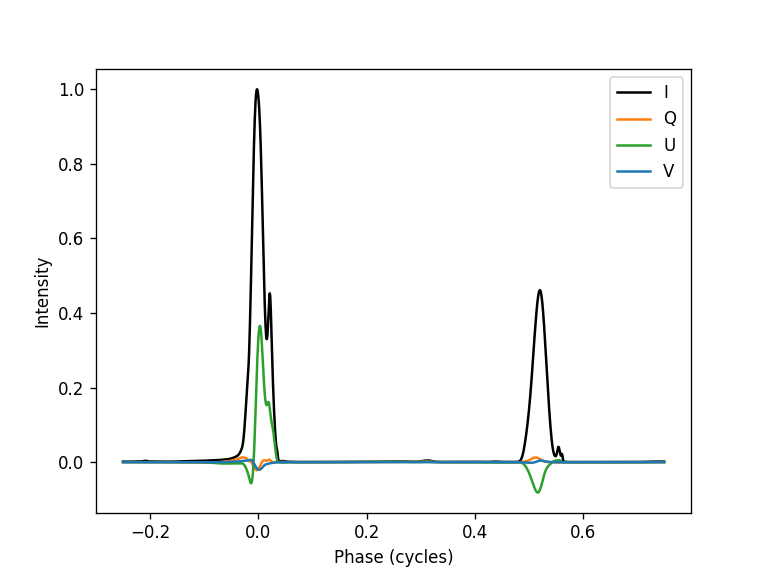

In [3]:
template.plot(what='IQUV', shift=0.25)
plt.show()

In [4]:
pulse_freq = 641.948222127829 # Hz
bandwidth = 1.5625e6 # Hz
predictor = FreqOnlyPredictor(pulse_freq, Time(60000, 0, 0))
model = BasebandModel(template, chan_bw=bandwidth, predictor=predictor)

In [5]:
data = model.sample(2**24)

<IPython.core.display.Javascript object>


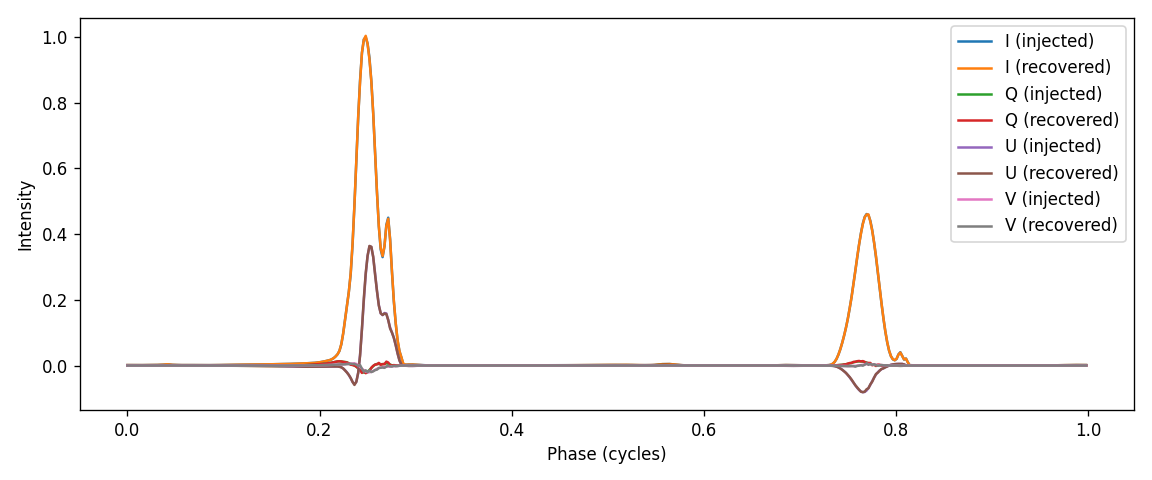

In [6]:
nbin = 512
phase = np.linspace(0, 1, nbin, endpoint=False)
I, Q, U, V = fold(data, nbin, predictor)
fig, ax = plt.subplots(figsize=(9.6, 4.0))
plt.plot(phase, np.roll(template.resample(nbin).I, nbin//4), label='I (injected)')
plt.plot(phase, np.roll(I.squeeze(), nbin//4), label='I (recovered)')
plt.plot(phase, np.roll(template.resample(nbin).Q, nbin//4), label='Q (injected)')
plt.plot(phase, np.roll(Q.squeeze(), nbin//4), label='Q (recovered)')
plt.plot(phase, np.roll(template.resample(nbin).U, nbin//4), label='U (injected)')
plt.plot(phase, np.roll(U.squeeze(), nbin//4), label='U (recovered)')
plt.plot(phase, np.roll(template.resample(nbin).V, nbin//4), label='V (injected)')
plt.plot(phase, np.roll(V.squeeze(), nbin//4), label='V (recovered)')
plt.legend()
plt.xlabel("Phase (cycles)")
plt.ylabel("Intensity")
plt.tight_layout()
plt.show()

In [7]:
%time pspec = pspec_numba(data, 128, 256, predictor, use_midpt=True)

CPU times: user 24.1 s, sys: 236 ms, total: 24.4 s
Wall time: 24.2 s


<IPython.core.display.Javascript object>


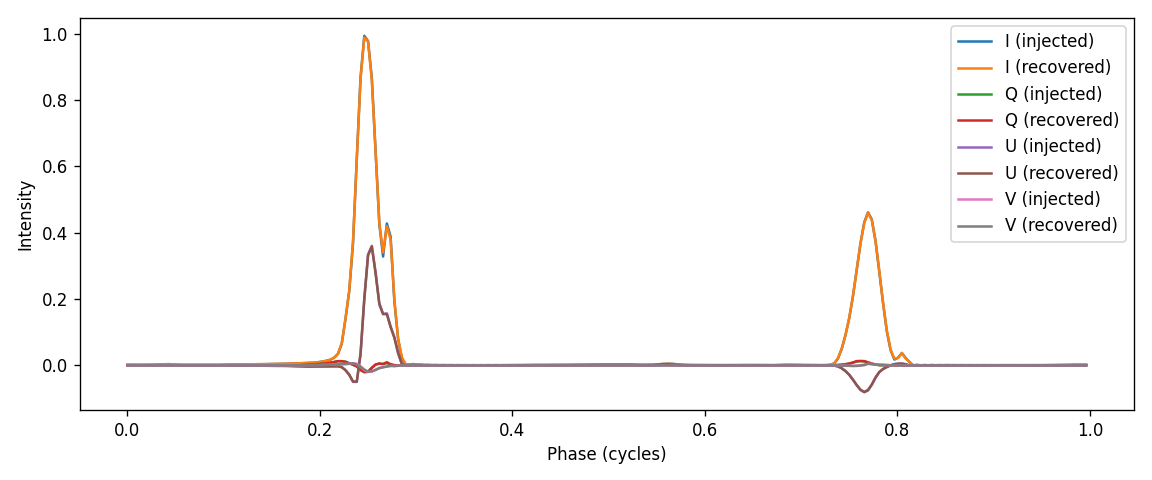

In [8]:
fig, ax = plt.subplots(figsize=(9.6, 4.0))
plt.plot(pspec.phase, np.roll(template.resample(256).I, 256//4), label='I (injected)')
plt.plot(pspec.phase, np.roll(np.mean(pspec.I, axis=0), 256//4), label='I (recovered)')
plt.plot(pspec.phase, np.roll(template.resample(256).Q, 256//4), label='Q (injected)')
plt.plot(pspec.phase, np.roll(np.mean(pspec.Q, axis=0), 256//4), label='Q (recovered)')
plt.plot(pspec.phase, np.roll(template.resample(256).U, 256//4), label='U (injected)')
plt.plot(pspec.phase, np.roll(np.mean(pspec.U, axis=0), 256//4), label='U (recovered)')
plt.plot(pspec.phase, np.roll(template.resample(256).V, 256//4), label='V (injected)')
plt.plot(pspec.phase, np.roll(np.mean(pspec.V, axis=0), 256//4), label='V (recovered)')
plt.legend()
plt.xlabel("Phase (cycles)")
plt.ylabel("Intensity")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


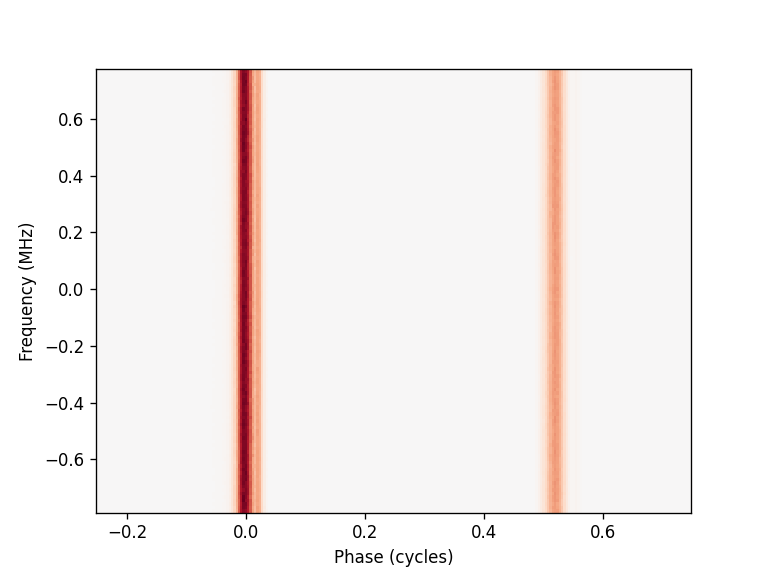

In [9]:
pspec.plot(what='I', shift=0.25, cmap='RdBu_r', sym_lim=True)
plt.show()

<IPython.core.display.Javascript object>


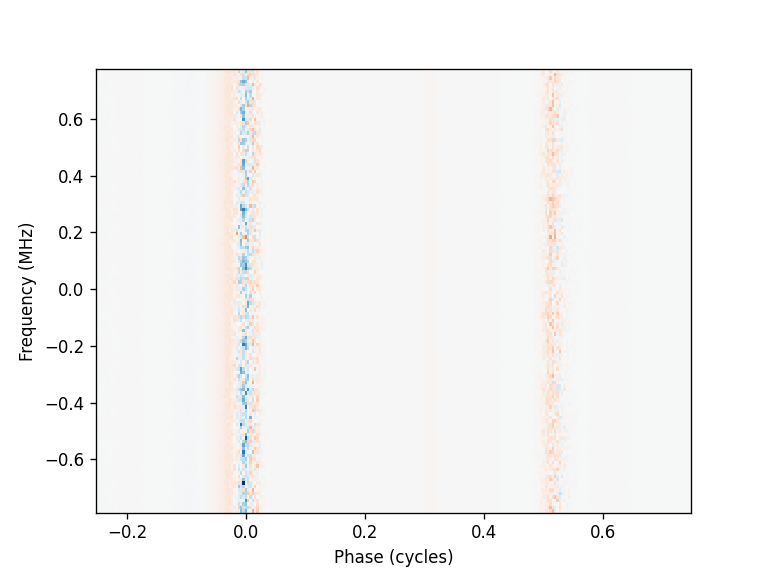

In [10]:
pspec.plot(what='Q', shift=0.25, cmap='RdBu_r', sym_lim=True)
plt.show()

<IPython.core.display.Javascript object>


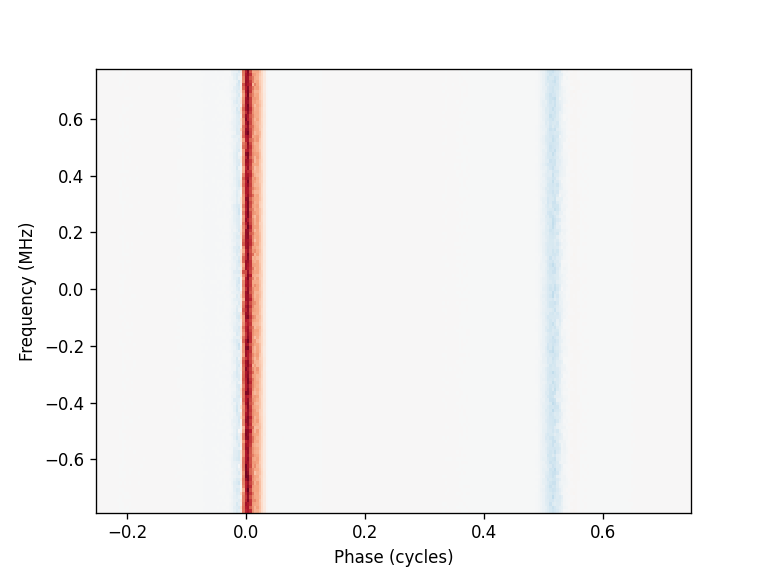

In [11]:
pspec.plot(what='U', shift=0.25, cmap='RdBu_r', sym_lim=True)
plt.show()

<IPython.core.display.Javascript object>


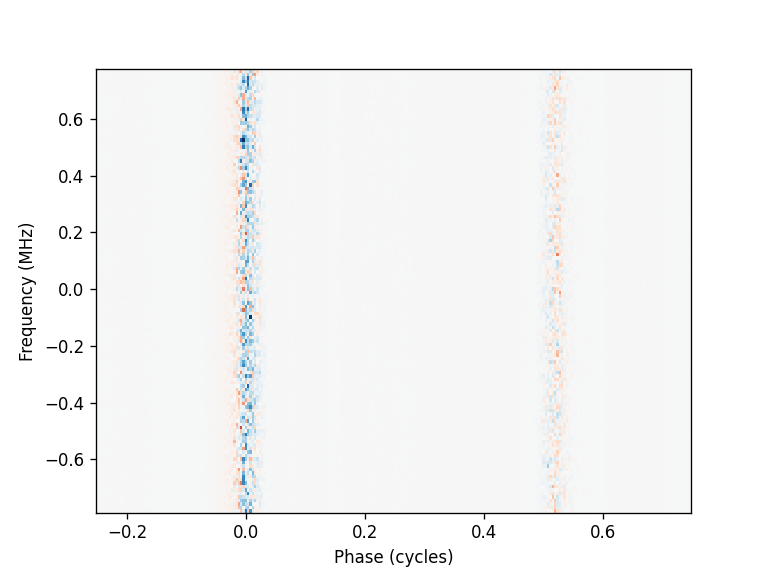

In [12]:
pspec.plot(what='V', shift=0.25, cmap='RdBu_r', sym_lim=True)
plt.show()

In [14]:
model = BasebandModel(template, chan_bw=bandwidth, predictor=predictor, feed_poln='CIRC')
data_circ = model.sample(2**24)

In [15]:
pspec_circ = pspec_numba(data_circ, 128, 256, predictor)

<IPython.core.display.Javascript object>


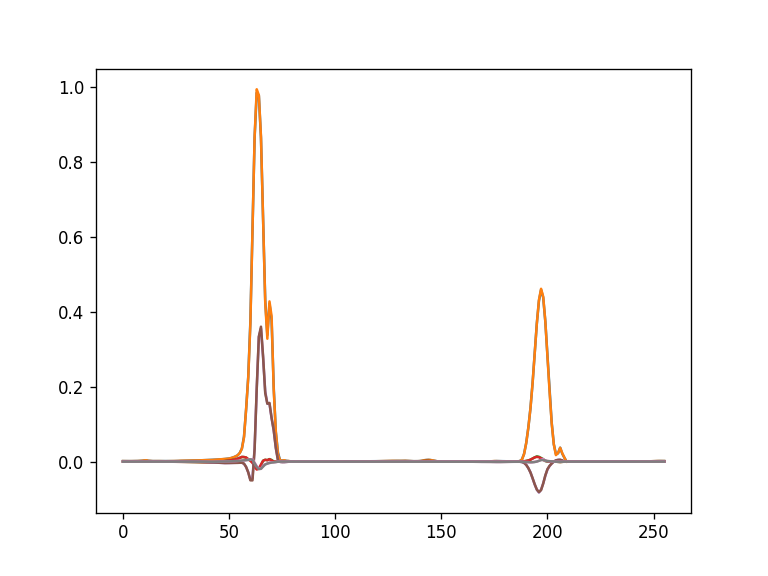

In [16]:
plt.plot(np.roll(np.mean(pspec_circ.I, axis=0), 256//4))
plt.plot(np.roll(template.resample(256).I, 256//4))
plt.plot(np.roll(np.mean(pspec_circ.Q, axis=0), 256//4))
plt.plot(np.roll(template.resample(256).Q, 256//4))
plt.plot(np.roll(np.mean(pspec_circ.U, axis=0), 256//4))
plt.plot(np.roll(template.resample(256).U, 256//4))
plt.plot(np.roll(np.mean(pspec_circ.V, axis=0), 256//4))
plt.plot(np.roll(template.resample(256).V, 256//4))
plt.show()